# Utils

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train - valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k: [z for z in zip(*log[k])] for k in keys}
    epochs = {k: range(len(log[k])) for k in keys}

    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

# Autoencoder

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def encode(self, x):
        with torch.no_grad():
            x = x.view(-1, 28*28)
            return self.E(x)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
models = {'2': Net(2), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def add_noise(x, mode='crop', elementwise=False):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2) * 2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                if np.random.randint(2):
                    x[i, ...] = torch.from_numpy(x.numpy()[i, :, ::-1, :].copy())
                else:
                    x[i, ...] = torch.from_numpy(x.numpy()[i, :, :, ::-1].copy())
        elif mode == 'gaussian':
            mean = 0
            var = 0.1
            sigma = var**0.5
            x = x + torch.from_numpy(np.random.normal(mean,sigma,x.shape)).float()
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2) * 2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x


In [47]:
def train(epoch, models, noized=False, mode='gaussian', log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        
        _input = add_noise(data, mode=mode, elementwise=True) if noized else data

        for model in models.values():
            model.optim.zero_grad()
            output = model(_input)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [48]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, noized=False, mode='gaussian', log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            _input = add_noise(data, mode=mode, elementwise=True) if noized else data
            output = {k: m(_input) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

### Для задачи 1 - обучение АК с 2 и 32 мерными латентными слоями

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 2: 1.098644 32: 1.012409
Train Epoch: 1 [30000/60000] 2: 1.020057 32: 0.669440
Train Epoch: 1 [60000/60000] 2: 0.998707 32: 0.421106
Test set:
2: loss: 1.0002
32: loss: 0.4056

Train Epoch: 2 [00000/60000] 2: 0.999282 32: 0.399222
Train Epoch: 2 [30000/60000] 2: 0.977125 32: 0.319725
Train Epoch: 2 [60000/60000] 2: 0.954440 32: 0.289559
Test set:
2: loss: 0.9565
32: loss: 0.2929

Train Epoch: 3 [00000/60000] 2: 0.955839 32: 0.290083
Train Epoch: 3 [30000/60000] 2: 0.924588 32: 0.280474
Train Epoch: 3 [60000/60000] 2: 0.885420 32: 0.277314
Test set:
2: loss: 0.8852
32: loss: 0.2769

Train Epoch: 4 [00000/60000] 2: 0.882433 32: 0.277415
Train Epoch: 4 [30000/60000] 2: 0.843115 32: 0.285881
Train Epoch: 4 [60000/60000] 2: 0.800779 32: 0.271167
Test set:
2: loss: 0.7980
32: loss: 0.2696

Train Epoch: 5 [00000/60000] 2: 0.793329 32: 0.267358
Train Epoch: 5 [30000/60000] 2: 0.751275 32: 0.256816
Train Epoch: 5 [60000/60000] 2: 0.717713 32: 0.268489
Test set:
2: l

### Задача 1а
#### отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем

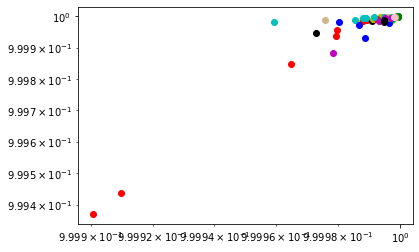

In [35]:
data, labels = next(iter(test_loader))
output = models['2'].encode(data[:100])
cmap = dict(zip(range(10), ['r','g','b','c','m','y','k', 'tan', 'lime', 'pink']))
for (x,y), label in zip(output.numpy(), labels.numpy()):
    plt.scatter(x,y, c=cmap[label])
plt.yscale('log')
plt.xscale('log')

### Задача 1б
#### сделать tSNE над 32-мерным латентным слоем, отрисовать представление

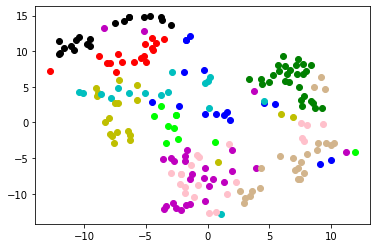

In [46]:
from sklearn.manifold import TSNE

data, labels = next(iter(test_loader))
output = models['32'].encode(data[:3000])

tsne_data = TSNE().fit_transform(output.numpy())


cmap = dict(zip(range(10), ['r','g','b','c','m','y','k', 'tan', 'lime', 'pink']))
for (x,y), label in zip(tsne_data[:200], labels.numpy()[:200]):
    plt.scatter(x,y, c=cmap[label])

## Задача 2 Обучить шумный автокодировщик: 

### Задача 2а. Добавить ко входным данным нормальный шум 

In [78]:
gauss_models = {'32': Net(32)}
gauss_train_log = {k: [] for k in gauss_models}
gauss_test_log = {k: [] for k in gauss_models}

for epoch in range(1, 21):
    for model in gauss_models.values():
        model.train()
    train(epoch, gauss_models, noized=True, mode='gaussian',  log=gauss_train_log)
    for model in gauss_models.values():
        model.eval()
    test(gauss_models, test_loader, noized=True, mode='gaussian', log=gauss_test_log)

Train Epoch: 1 [00000/60000] 32: 1.013165
Train Epoch: 1 [30000/60000] 32: 0.678100
Train Epoch: 1 [60000/60000] 32: 0.405195
Test set:
32: loss: 0.4054

Train Epoch: 2 [00000/60000] 32: 0.404849
Train Epoch: 2 [30000/60000] 32: 0.319741
Train Epoch: 2 [60000/60000] 32: 0.288772
Test set:
32: loss: 0.2910

Train Epoch: 3 [00000/60000] 32: 0.284948
Train Epoch: 3 [30000/60000] 32: 0.279915
Train Epoch: 3 [60000/60000] 32: 0.269898
Test set:
32: loss: 0.2668

Train Epoch: 4 [00000/60000] 32: 0.263035
Train Epoch: 4 [30000/60000] 32: 0.254650
Train Epoch: 4 [60000/60000] 32: 0.245838
Test set:
32: loss: 0.2501

Train Epoch: 5 [00000/60000] 32: 0.243943
Train Epoch: 5 [30000/60000] 32: 0.234982
Train Epoch: 5 [60000/60000] 32: 0.227890
Test set:
32: loss: 0.2357

Train Epoch: 6 [00000/60000] 32: 0.236221
Train Epoch: 6 [30000/60000] 32: 0.225655
Train Epoch: 6 [60000/60000] 32: 0.223591
Test set:
32: loss: 0.2226

Train Epoch: 7 [00000/60000] 32: 0.227827
Train Epoch: 7 [30000/60000] 32: 0

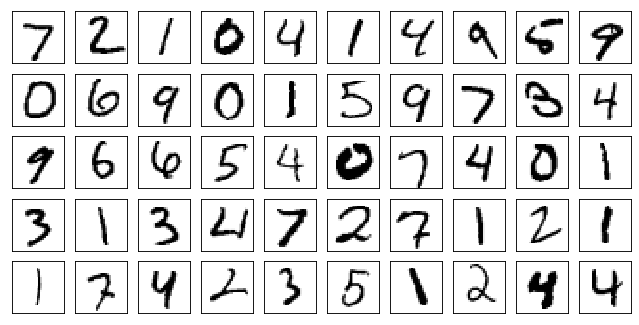

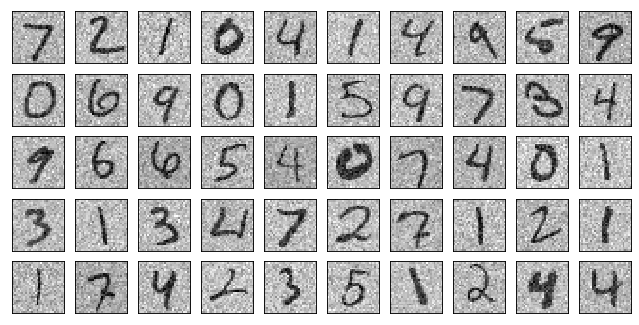

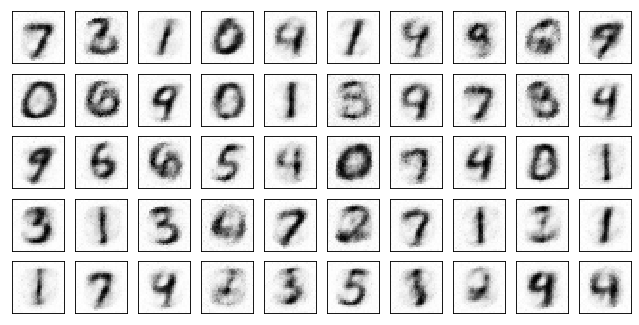

In [79]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', elementwise=True)
output = gauss_models['32'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

### Задача 2б. Сделать отражение части изображения 

In [80]:
mirror_models = {'32': Net(32)}
mirror_train_log = {k: [] for k in mirror_models}
mirror_test_log = {k: [] for k in mirror_models}

for epoch in range(1, 21):
    for model in mirror_models.values():
        model.train()
    train(epoch, mirror_models, noized=True, mode='mirror',  log=mirror_train_log)
    for model in mirror_models.values():
        model.eval()
    test(mirror_models, test_loader, noized=True, mode='mirror', log=mirror_test_log)

Train Epoch: 1 [00000/60000] 32: 1.007833
Train Epoch: 1 [30000/60000] 32: 0.647211
Train Epoch: 1 [60000/60000] 32: 0.396246
Test set:
32: loss: 0.3998

Train Epoch: 2 [00000/60000] 32: 0.400089
Train Epoch: 2 [30000/60000] 32: 0.314017
Train Epoch: 2 [60000/60000] 32: 0.290178
Test set:
32: loss: 0.2902

Train Epoch: 3 [00000/60000] 32: 0.286129
Train Epoch: 3 [30000/60000] 32: 0.267409
Train Epoch: 3 [60000/60000] 32: 0.265114
Test set:
32: loss: 0.2694

Train Epoch: 4 [00000/60000] 32: 0.264819
Train Epoch: 4 [30000/60000] 32: 0.255208
Train Epoch: 4 [60000/60000] 32: 0.253267
Test set:
32: loss: 0.2571

Train Epoch: 5 [00000/60000] 32: 0.245666
Train Epoch: 5 [30000/60000] 32: 0.256358
Train Epoch: 5 [60000/60000] 32: 0.246005
Test set:
32: loss: 0.2472

Train Epoch: 6 [00000/60000] 32: 0.238448
Train Epoch: 6 [30000/60000] 32: 0.236436
Train Epoch: 6 [60000/60000] 32: 0.240954
Test set:
32: loss: 0.2384

Train Epoch: 7 [00000/60000] 32: 0.238342
Train Epoch: 7 [30000/60000] 32: 0

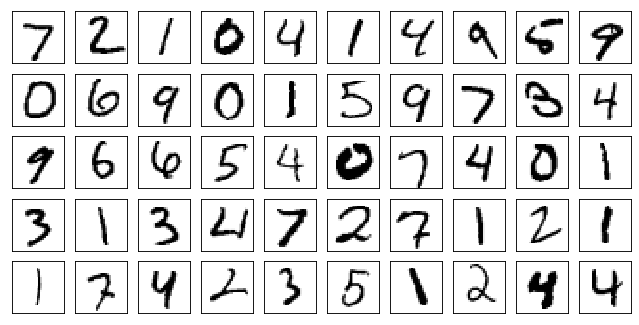

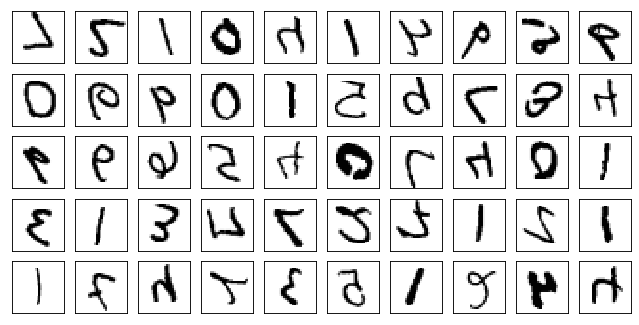

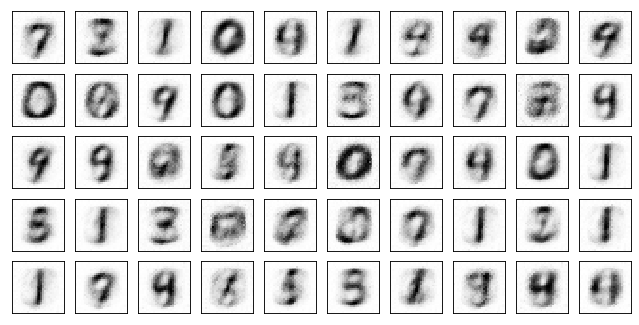

In [84]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='mirror', elementwise=True)
output = mirror_models['32'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

### Задача 2в. 
#### Отрисовать карты активаций нейронов первого слоя

Модель с гауссовским шумом

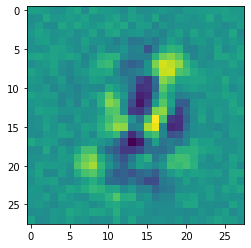

In [86]:
plt.imshow(list(gauss_models['32'].E.fc1.parameters())[0][0].view(28,28).detach().numpy())

Модель с зеркальными отражениями

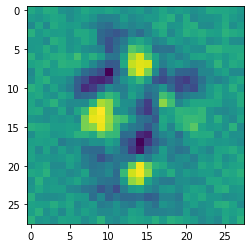

In [87]:
plt.imshow(list(mirror_models['32'].E.fc1.parameters())[0][0].view(28,28).detach().numpy())